# PCA Model Task

### 1) Data Preparation

In [5]:
#!pip install tflearn

Importing packages

In [44]:
import datetime
import pandas as pd
from pandas import Series
from pandas import DataFrame
from pandas import concat
import numpy as np
import time, datetime
import matplotlib.pyplot as plt
import sys
import string
from collections import Counter
from nltk import ngrams
import itertools
import random
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.datasets import make_classification  
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split  
from sklearn.metrics import roc_curve  
from sklearn.metrics import roc_auc_score
from sklearn import preprocessing

##### Reading the data, converting the time to timestamp and indexing the date to use it as a time series

In [57]:
#Data Paths
DATA_PATH = sys.path[0]+"\\data\\"
filename_train1="BATADAL_dataset03.csv"
filename_train2="BATADAL_dataset04.csv"
filename_test="BATADAL_test_dataset.csv"

#Reading the data
dftrain1  = pd.read_csv(DATA_PATH + filename_train1)
dftrain2  = pd.read_csv(DATA_PATH + filename_train2)
dftest  = pd.read_csv(DATA_PATH + filename_test)

# Modify string date to timestamp
dftrain1.DATETIME = dftrain1.DATETIME.apply(lambda s: pd.to_datetime(s,format='%d/%m/%y %H'))
dftrain2.DATETIME = dftrain2.DATETIME.apply(lambda s: pd.to_datetime(s,format='%d/%m/%y %H'))
dftest.DATETIME = dftest.DATETIME.apply(lambda s: pd.to_datetime(s,format='%d/%m/%y %H'))

# Choosing 0 if not an anomaly and 1 if anomaly
dftrain2[' ATT_FLAG']=dftrain2[' ATT_FLAG'].apply(lambda x: 0 if x==-999 else x)

# Indexing
dftrain1=dftrain1.set_index('DATETIME')
dftrain2=dftrain2.set_index('DATETIME')
dftest=dftest.set_index('DATETIME')

#dftrain1.shift(1)

##### Dropping variables that are not meant to be used in for prediction (levers).

In [70]:
dftrain1=dftrain1.drop(['S_PU1','S_PU2','S_PU3','S_PU4','S_PU5','S_PU6','S_PU7','S_PU8','S_PU9','S_PU10','S_PU11','S_V2'],axis=1)
dftrain2=dftrain2.drop([' S_PU1',' S_PU2',' S_PU3',' S_PU4',' S_PU5',' S_PU6',' S_PU7',' S_PU8', ' S_PU9',' S_PU10',' S_PU11',' S_V2'],axis=1)

##### Normalizing the data

All columns but the last column with the binary classification of anomaly.

In [72]:
#Obs: some values will be converted to float
#Dftrain1
dftrain1.iloc[:,range(0,31)]=preprocessing.scale(dftrain1.iloc[:,range(0,31)])
#Dftrain2
dftrain2.iloc[:,range(0,31)]=preprocessing.scale(dftrain2.iloc[:,range(0,31)])

##### Labling the attacks on dftrain2 according to the information below

###### For L_T7
13/09/2016 23 - 16/09/2016 00 |
26/09/2016 11 - 27/09/2016 10
###### For F_PU10 and F_PU11
26/09/2016 11 - 27/09/2016 10
###### For L_T1
09/10/2016 9 - 11/10/2016 20 |
29/10/2016 19 - 02/11/2016 16 |
14/12/2016 15 - 19/12/2016 04
###### For F_PU1 and F_PU2
29/10/2016 19 - 02/11/2016 16 |
14/12/2016 15 - 19/12/2016 04
###### For L_T4
26/11/2016 17 - 29/11/2016 04

In [15]:
#L_T7
dftrain2_L_T7=dftrain2.loc[:,[' L_T7',' ATT_FLAG']]
dftrain2_L_T7.loc[:,' ATT_FLAG']=0
dftrain2_L_T7.loc['2016-09-13 23':'2016-09-16 00',' ATT_FLAG']=1
dftrain2_L_T7.loc['2016-09-26 11':'2016-09-27 10',' ATT_FLAG']=1
#F_PU10 and F_PU11
dftrain2_F_PU10=dftrain2.loc[:,[' F_PU10',' ATT_FLAG']]
dftrain2_F_PU10.loc[:,' ATT_FLAG']=0
dftrain2_F_PU10.loc['2016-09-26 11':'2016-09-27 10',' ATT_FLAG']=1

dftrain2_F_PU11=dftrain2.loc[:,[' F_PU11',' ATT_FLAG']]
dftrain2_F_PU11.loc[:,' ATT_FLAG']=0
dftrain2_F_PU11.loc['2016-09-26 11':'2016-09-27 10',' ATT_FLAG']=1
#L_T1
dftrain2_L_T1=dftrain2.loc[:,[' L_T1',' ATT_FLAG']]
dftrain2_L_T1.loc[:,' ATT_FLAG']=0
dftrain2_L_T1.loc['2016-10-09 09':'2016-10-11 20',' ATT_FLAG']=1
dftrain2_L_T1.loc['2016-10-29 19':'2016-11-02 16',' ATT_FLAG']=1
dftrain2_L_T1.loc['2016-12-14 15':'2016-12-19 04',' ATT_FLAG']=1
#F_PU1 and F_PU2
dftrain2_F_PU1=dftrain2.loc[:,[' F_PU1',' ATT_FLAG']]
dftrain2_F_PU1.loc[:,' ATT_FLAG']=0
dftrain2_F_PU1.loc['2016-10-29 19':'2016-11-02 16',' ATT_FLAG']=1
dftrain2_F_PU1.loc['2016-12-14 15':'2016-12-19 04',' ATT_FLAG']=1

dftrain2_F_PU2=dftrain2.loc[:,[' F_PU2',' ATT_FLAG']]
dftrain2_F_PU2.loc[:,' ATT_FLAG']=0
dftrain2_F_PU2.loc['2016-10-29 19':'2016-11-02 16',' ATT_FLAG']=1
dftrain2_F_PU2.loc['2016-12-14 15':'2016-12-19 04',' ATT_FLAG']=1
#L_T4
dftrain2_L_T4=dftrain2.loc[:,[' L_T4',' ATT_FLAG']]
dftrain2_L_T4.loc[:,' ATT_FLAG']=0
dftrain2_L_T4.loc['2016-11-26 17':'2016-11-29 04',' ATT_FLAG']=1

#dftrain2[' ATT_FLAG']=dftrain2[' ATT_FLAG'].apply(lambda x: 0 if x==-999 else x)

## 2) Creating Functions to Evaluate Performance

_Observation: some of the code used here was derived from the website: This method was derived from: https://www.oreilly.com/library/view/hands-on-unsupervised-learning/9781492035633/ch04.html that performed a similar analisis using PCA_

### Reverse Anomaly Scores

The transactions that have the largest sum of squared differences will have an error close to zero, while those that have the smallest sum of squared differences will have an error close to one.

In [155]:
def ReverseAnomalyScore(originalDF, reducedDF):
    #Calculating the square loss
    loss = np.sum((np.array(originalDF)-np.array(reducedDF))**2, axis=1)
    #Changing format
    loss = pd.Series(data=loss,index=originalDF.index)
    #Scaling between 0 and 1
    loss = (loss-np.min(loss))/(np.max(loss)-np.min(loss))
    #Revrsing the order
    score=1-loss
    return score

### Performance

Plot anomaly scores and performance metrics. Return predictions if the user wants

In [154]:
def plotResults(trueLabels, anomalyScores, returnPreds = False):
    preds = pd.concat([trueLabels, anomalyScores], axis=1)
    preds.columns = ['trueLabel', 'anomalyScore']
    precision, recall, thresholds = \
        precision_recall_curve(preds['trueLabel'],preds['anomalyScore'])
    average_precision = \
        average_precision_score(preds['trueLabel'],preds['anomalyScore'])

    plt.step(recall, precision, color='k', alpha=0.7, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.3, color='k')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])

    plt.title('Precision-Recall curve: Average Precision = \
    {0:0.2f}'.format(average_precision))

    fpr, tpr, thresholds = roc_curve(preds['trueLabel'], \
                                     preds['anomalyScore'])
    areaUnderROC = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='r', lw=2, label='ROC curve')
    plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic: \
    Area under the curve = {0:0.2f}'.format(areaUnderROC))
    plt.legend(loc="lower right")
    plt.show()

    if returnPreds==True:
        return preds

In [ ]:
def pca_performance(ReverseAnomalyScoresPCA,trueLabels):

# 3) PCA Algorithm

#### Running the PCA for the entire train dataset 1
Running the PCA, reversing the PCA to rebuild the dataset and storing it in a dataframe

In [134]:
#Creating the function
def pca_reverse_trasformation(n_components,random_state,df):
    #Creating PCA model
    pca = PCA(n_components=n_components, whiten=False, random_state=random_state)
    #Applyting PCA transformation to dataset
    df_PCA = pca.fit_transform(df)
    #Saving in a dataframe format
    df_PCA = pd.DataFrame(data=df_PCA, index=df.index)
    #Reversing the PCA
    df_PCA_inverse = pca.inverse_transform(df_PCA)
    #Saving in a dataframe format
    df_PCA_inverse = pd.DataFrame(data=df_PCA_inverse,index=df.index)
    return df_PCA_inverse

#Applying the function
n_components = 10
random_state = 27
df=dftrain1
dftrain1_PCA_inverse=pca_reverse_trasformation(n_components,random_state,df)

#### Calculating the residuals


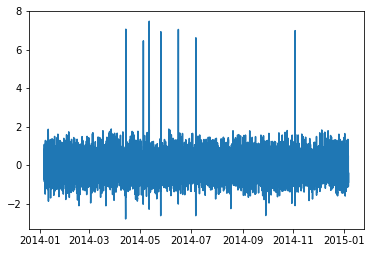

In [156]:
def residuals_pca(original_column,pca_column):
    #Creating DF with the selected column from the transformed dataset
    PCA_L_T4=pd.DataFrame(data=pca_column,index=pca_column.index)
    PCA_L_T4.columns = ['transformed']
    PCA_L_T4["original"]=original_column
    #Calculating the residuals
    PCA_L_T4["residuals"]=PCA_L_T4["original"]-PCA_L_T4['transformed']
    return  PCA_L_T4

#Testing
original_column=dftrain2["L_T4"]
pca_column=dftrain1_PCA_inverse[dftrain1.columns.get_loc("L_T4")]
PCA_L_T4=residuals_pca(original_column,pca_column)
#Plot
plt.plot(PCA_L_T4["residuals"])

# 4) Predicting Anomalies

Calculating anomaly scores for each row

In [153]:
ReverseAnomalyScoresPCA = ReverseAnomalyScore(dftrain1, dftrain1_PCA_inverse)
##preds = plotResults(y_train, anomalyScoresPCA, True)

#### Creating function that iteratively